In [1]:
from ftpr.dataloader import load_phases
from ftpr.visualization import PhaseVisualizer
from ftpr.clustering import PhaseClustering
import pandas as pd
import numpy as np
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
team = 'Manchester City'
df = pd.read_csv(f'../data/team_phases/{team}.csv')
phases = load_phases(df, filter_static_events=True, min_phase_length=3, n_jobs=5)

In [3]:
len(phases)

4849

In [4]:
phases[0]._df['timestamp'][0]

'00:00:17.793'

In [5]:
a = pd.Timestamp(phases[0]._df['timestamp'][0])
b = pd.Timestamp(phases[0]._df['timestamp'][1])
(b - a).seconds

1

In [6]:
ids = []
col_index = phases[0]._df.columns.get_loc('timestamp')

for id, phase in enumerate(phases):
    for i in range(1, len(phase) - 1):
        # print(phase._df['timestamp'])
        a = pd.Timestamp(phase._df.iloc[i, col_index])
        b = pd.Timestamp(phase._df.iloc[i + 1, col_index])
        if (b - a).seconds >= 10:
                        ids.append(id)
                        break

In [7]:
ids[0]

203

In [8]:
phases[ids[2]]._df

,Unnamed: 0,ball_receipt_outcome,carry_end_location,dribble_outcome,id,index,location,match_id,out,pass_angle,...,shot_statsbomb_xg,shot_type,tactics,team,team_id,timestamp,type,foul_won_penalty,pass_goal_assist,phase_id
2812,3412,NaN,NaN,NaN,0c07ff13-3b59-46a3-a658-8198c6b45dec,2488,"[4.8, 62.5]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:14:09.118,Block,NaN,NaN,670
2813,3510,NaN,NaN,NaN,5dfe4b79-d9d6-4a46-802b-93f0c09aced3,2489,"[1.9, 43.9]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:14:10.303,Ball Recovery,NaN,NaN,670
2814,2537,NaN,"[16.1, 36.8]",NaN,68619711-0b70-4588-adf6-96867ac574ce,2490,"[1.9, 43.9]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:14:10.303,Carry,NaN,NaN,670
2815,710,NaN,NaN,NaN,45b0d3d4-f735-4228-96c8-219979b1e85d,2491,"[16.1, 36.8]",3754015,NaN,-0.374469,...,NaN,NaN,NaN,Manchester City,36,00:14:25.799,Pass,NaN,NaN,670


In [9]:
phase = phases[300]
phase._df

,Unnamed: 0,ball_receipt_outcome,carry_end_location,dribble_outcome,id,index,location,match_id,out,pass_angle,...,shot_statsbomb_xg,shot_type,tactics,team,team_id,timestamp,type,foul_won_penalty,pass_goal_assist,phase_id
2425,3446,NaN,NaN,NaN,80736b03-3fe1-4741-b5ac-0385d767796a,619,"[15.3, 46.4]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:15:09.913,Ball Recovery,NaN,NaN,556
2426,2120,NaN,"[21.1, 49.7]",NaN,06911d3e-ea85-4146-a3bc-a225611513b9,620,"[15.3, 46.4]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:15:09.913,Carry,NaN,NaN,556
2427,194,NaN,NaN,NaN,0f79bb60-6944-4f90-a1ff-c5b2823a3e82,621,"[21.1, 49.7]",3754015,NaN,-0.120490,...,NaN,NaN,NaN,Manchester City,36,00:15:11.033,Pass,NaN,NaN,556
2428,195,NaN,NaN,NaN,56a62dd3-d483-4703-b53a-4e724cd0447a,623,"[43.4, 47.0]",3754015,NaN,-1.156289,...,NaN,NaN,NaN,Manchester City,36,00:15:12.823,Pass,NaN,NaN,556
2429,2121,NaN,"[51.8, 30.2]",NaN,06048165-c961-4fce-862c-6bff25711a1d,625,"[52.2, 27.0]",3754015,NaN,NaN,...,NaN,NaN,NaN,Manchester City,36,00:15:14.663,Carry,NaN,NaN,556


In [10]:
events_config = {
    'Pass': {
        'color': '#00ffff'
    },
    'Carry': {
        'color': '#00aa00',
        'dashed': True
    },
    'Shot': {
        'color': '#aa0000'
    } 
}

In [11]:
location_columns = ['location', 'pass_end_location', 'carry_end_location', 'shot_end_location']

(<Figure size 1600x1100 with 1 Axes>, <Axes: >)

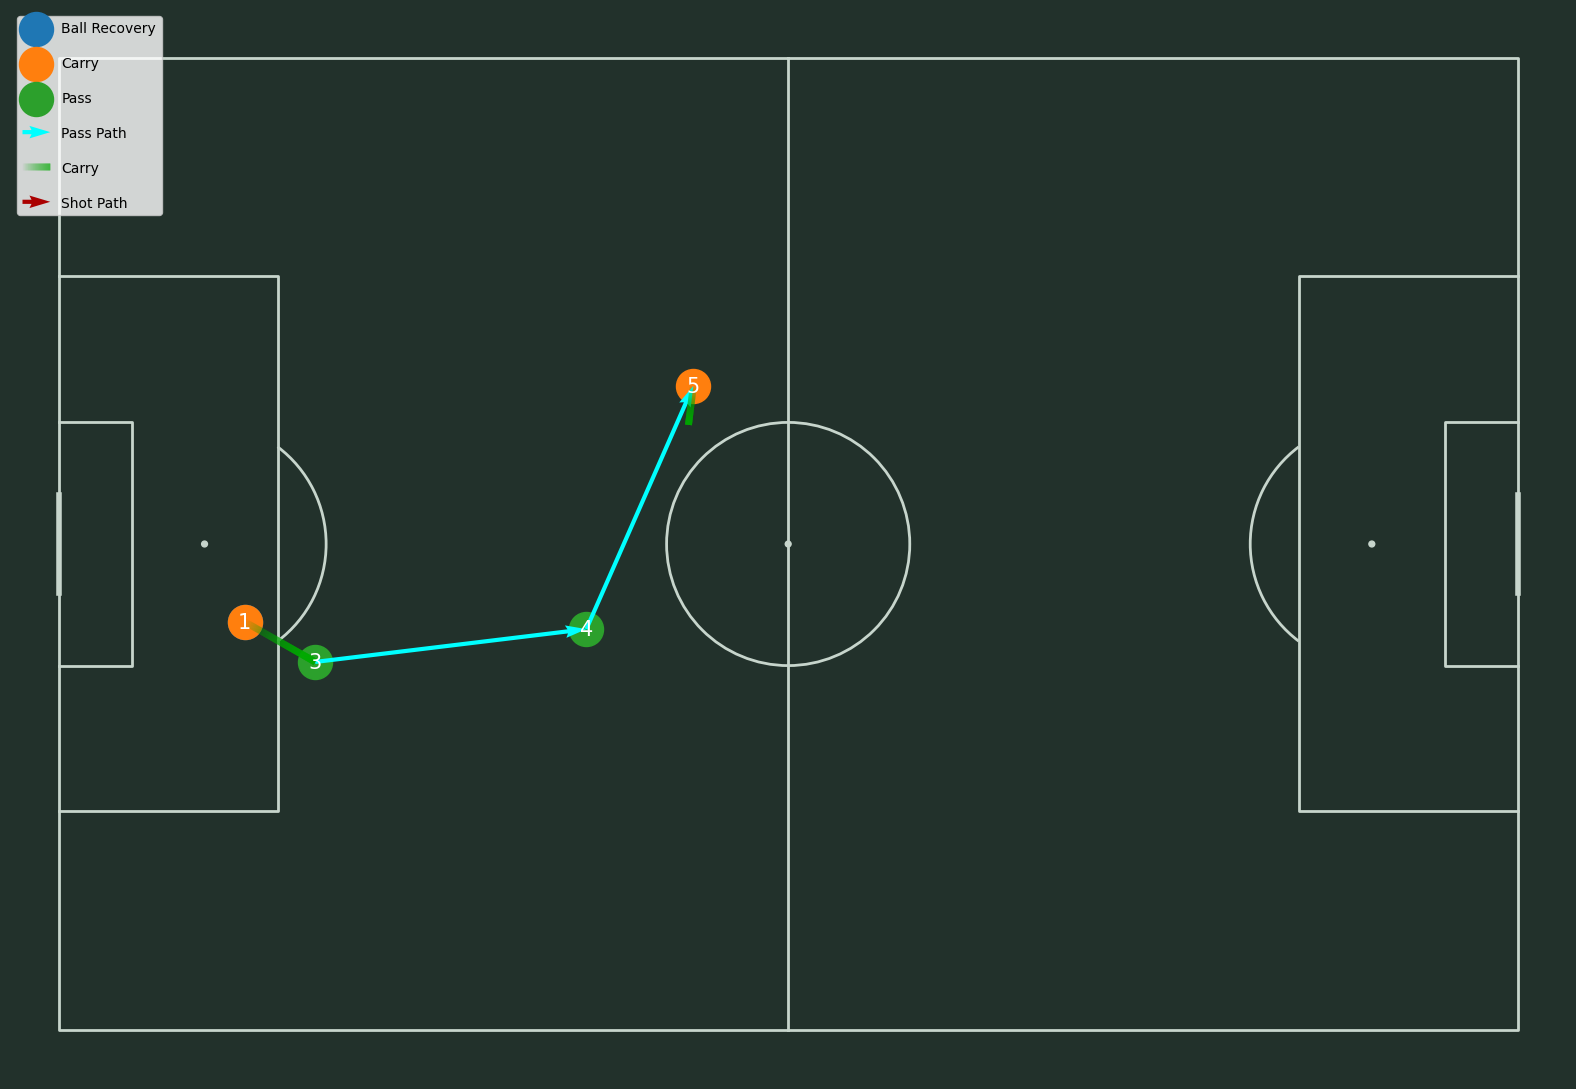

In [12]:
vis = PhaseVisualizer((16, 11))
phase = phase.split_locations(location_columns)
vis.plot_phase(phase, events_config=events_config)

In [13]:
series = phase.get_location_series(remove_duplicates=True)
series

[[15.3, 46.4], [21.1, 49.7], [43.4, 47.0], [52.2, 27.0], [51.8, 30.2]]

In [14]:
def get_bin(x, y):
    return x // 4, y // 4

def get_bin_center(bin_x, bin_y):
    return bin_x * 4 + 2, bin_y * 4 + 2

In [15]:
def get_interpolated_series(series):
	assert len(series) >= 2
	result = [series[0], series[1]]
	i = 1
	j = 2
	while j < len(series):
		this_bin = get_bin(result[i][0], result[i][1])
		prev_bin = get_bin(result[i-1][0], result[i-1][1])
		if abs(this_bin[0] - prev_bin[0]) > 1 or abs(this_bin[1] - prev_bin[1]) > 1:
			mid_point = [(result[i-1][0] + result[i][0]) / 2, (result[i-1][1] + result[i][1])/2]
			result.insert(i, mid_point)
		else:
			i += 1
			if i == len(result):
				result.append(series[j])
				j += 1
	return result

In [16]:
new_series = get_interpolated_series(series)
new_series

[[15.3, 46.4],
 [18.200000000000003, 48.05],
 [21.1, 49.7],
 [26.675, 49.025000000000006],
 [29.4625, 48.6875],
 [32.25, 48.35],
 [37.825, 47.675],
 [43.4, 47.0],
 [45.599999999999994, 42.0],
 [47.8, 37.0],
 [50.0, 32.0],
 [51.1, 29.5],
 [52.2, 27.0],
 [51.8, 30.2]]

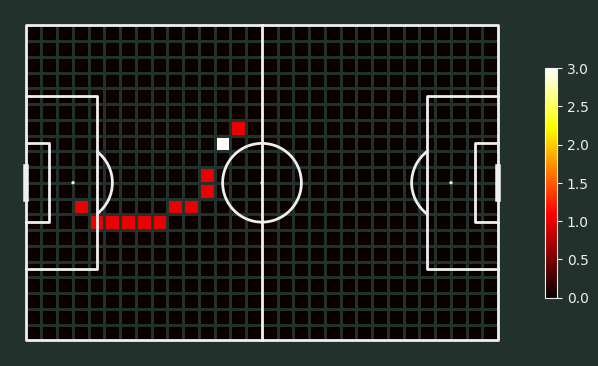

In [17]:
x = [t[0] for t in new_series]
y = [t[1] for t in new_series]

pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef')

fig, ax = pitch.draw(figsize=(6.6, 4.125))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(120 // 4, 80 // 4))
# bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')

In [18]:
n_clusters = 100
pc = PhaseClustering(phases)
cls_pred, clustering = pc.agglomerative_fit(n_clusters=n_clusters, metric='dtw')

In [19]:
cluster_score = [0 for _ in range(n_clusters)]
cluster_dist = []
for cluster_id in range(n_clusters):
	phases_in_cluster = pc.get_cluster_phases(cluster_id)
	cluster_dist.append(len(phases_in_cluster))
	for phase in phases_in_cluster:
		cluster_score[cluster_id] += Counter(phase['type']).get('Shot', 0)
cluster_score = np.array(cluster_score)
best_cluster_indeces = np.argsort(cluster_score)[::-1]

In [20]:
best_cluster_indeces[0]

35

In [21]:
series_in_cluster = pc.get_cluster_series(best_cluster_indeces[15])

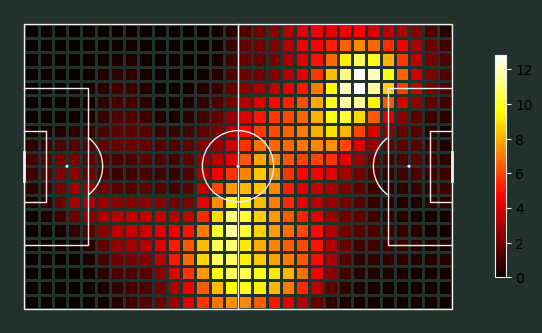

In [26]:
new_series = []
for series in series_in_cluster:
    new_series.extend(get_interpolated_series(series))

x = [t[0] for t in new_series]
y = [t[1] for t in new_series]

pitch = Pitch(pitch_type='statsbomb', line_zorder=2,
              pitch_color='#22312b', line_color='#efefef', linewidth=1)

fig, ax = pitch.draw(figsize=(6, 4))
fig.set_facecolor('#22312b')
bin_statistic = pitch.bin_statistic(x, y, statistic='count', bins=(120 // 4, 80 // 4))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')
ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')